# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Análisis de grandes volúmenes de datos (Gpo 10)**

### Tecnológico de Monterrey

## **Actividad 4**

###  *Métricas de calidad de resultados*


#### **Nombrey matrícula**

*   **A01746998** - Alexys Martín Coate Reyes


# **1. Construcción de la muestra M**



### Cargando los datos

In [1]:
# Librerias
from pyspark.sql import SparkSession

In [2]:
# Crear sesión Spark
spark = SparkSession.builder \
    .appName("EDA_Vuelos") \
    .getOrCreate()

# Leer el CSV
df = spark.read.csv("../Dataset/Airline_Delay_2016-2018.csv", header=True, inferSchema=True)

# Mostrar esquema de datos
df.printSchema()

# Número total de registros
df_count = df.count()
print(f"Número total de registros: {df_count}")

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)

Número total de registros: 18505725


In [3]:
# Imprimiendo los 3 primeros rengloes del dataframe dataframe
df.show(3)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+
|2016-01-01|        DL|             1248|   DTW| LAX|        1935|  1935.0|      0.0|    23.0|    1958.0|   2107.0|   13.0|        2144|  2120.0|    -24.0|      0.0|     0.0|           309.0|              285.0|   249.0|  1979.0|
|2016-01-01|        DL|             1251|   ATL| GRR|        2125|  2130.0|     

De acuerdo con los datos analizados anteriormente concluimos que podemos crear un modelo que regresión que prediga el retraso de los aviones, teniendo como variable objetivo ARR_DELAY.

Conforme a esto procedemos a realizar la selección de variables de caracterización para este problema, que consiste en seleccionar las varibles más importantes para la modelación del problema.

### Analizando los distintos tipos de datos dentro del dataframe

In [4]:
# Conteo de CANCELLED
print("=== Conteo de CANCELLED ===")
df.groupBy("CANCELLED").count().show()

# Conteo de DIVERTED
print("=== Conteo de DIVERTED ===")
df.groupBy("DIVERTED").count().show()

=== Conteo de CANCELLED ===
+---------+--------+
|CANCELLED|   count|
+---------+--------+
|      0.0|18240587|
|      1.0|  265138|
+---------+--------+

=== Conteo de DIVERTED ===
+--------+--------+
|DIVERTED|   count|
+--------+--------+
|     0.0|18461684|
|     1.0|   44041|
+--------+--------+



In [5]:
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.types import NumericType, StringType, DateType, TimestampType

def resumen_descriptivo(df):
    print("📊 Estadísticas Descriptivas Generales:\n")

    for field in df.schema.fields:
        nombre = field.name
        tipo = field.dataType

        print(f"\n📌 Columna: {nombre}  |  Tipo: {tipo.simpleString()}")
        print("-" * 50)

        # Si es numérico
        if isinstance(tipo, NumericType):
            df.select(nombre).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

        # Si es categórica o de fecha
        elif isinstance(tipo, (StringType, DateType, TimestampType)):
            total = df.count()
            distintos = df.select(nombre).distinct().count()
            print(f"Valores únicos: {distintos} / {total}")
            print("Top 5 valores más frecuentes:")
            df.groupBy(nombre).count().orderBy("count", ascending=False).show(5)

        else:
            print("Tipo de dato no analizado automáticamente.")

resumen_descriptivo(df)

📊 Estadísticas Descriptivas Generales:


📌 Columna: FL_DATE  |  Tipo: date
--------------------------------------------------
Valores únicos: 1096 / 18505725
Top 5 valores más frecuentes:
+----------+-----+
|   FL_DATE|count|
+----------+-----+
|2018-11-25|22160|
|2018-07-13|22022|
|2018-07-20|22002|
|2018-07-27|21997|
|2018-08-03|21990|
+----------+-----+
only showing top 5 rows


📌 Columna: OP_CARRIER  |  Tipo: string
--------------------------------------------------
Valores únicos: 18 / 18505725
Top 5 valores más frecuentes:
+----------+-------+
|OP_CARRIER|  count|
+----------+-------+
|        WN|3981440|
|        DL|2795589|
|        AA|2727661|
|        OO|2086597|
|        UA|1751113|
+----------+-------+
only showing top 5 rows


📌 Columna: OP_CARRIER_FL_NUM  |  Tipo: int
--------------------------------------------------
+-------+------------------+
|summary| OP_CARRIER_FL_NUM|
+-------+------------------+
|  count|          18505725|
|   mean| 2304.635922451025|
| stddev|17

### Seleccionando variables de caracterización

**Variables relacionadas con el tiempo:**

* `FL_DATE`: La fecha del vuelo puede ser importante para identificar patrones estacionales o días de la semana con mayor probabilidad de retraso.

* `CRS_DEP_TIME`: La hora programada de salida puede influir en los retrasos (por ejemplo, vuelos en horas pico).

* `DEP_TIME`: La hora real de salida. La diferencia entre  `DEP_TIME` y `CRS_DEP_TIME` (`DEP_DELAY`) es una variable predictora muy fuerte para `ARR_DELAY`.

* `TAXI_OUT`: El tiempo que tarda el avión en rodar desde la puerta de embarque hasta la pista de despegue. Tiempos de taxi largos pueden indicar congestión o problemas.

* `WHEELS_OFF`: La hora en que las ruedas del avión dejan el suelo. Relacionado con `TAXI_OUT` y `DEP_TIME`.

* `WHEELS_ON`: La hora en que las ruedas del avión tocan tierra. Relacionado con `AIR_TIME` y `TAXI_IN`.

* `TAXI_IN`: El tiempo que tarda el avión en rodar desde la pista de aterrizaje hasta la puerta de embarque.



**Variables operacionales y de ruta:**

* `OP_CARRIER`: La aerolínea operadora. Algunas aerolíneas pueden tener una mayor propensión a sufrir retrasos.

* `ORIGIN`: El aeropuerto de origen. Ciertos aeropuertos pueden experimentar más retrasos debido a su tamaño, ubicación geográfica o congestión.

* `DEST`: El aeropuerto de destino. Similar al aeropuerto de origen.

* `DISTANCE`: La distancia del vuelo. Los vuelos de larga distancia podrían ser más susceptibles a retrasos acumulados.

* `OP_CARRIER_FL_NUM`: El número de vuelo. Podría usarse para identificar rutas específicas o vuelos recurrentes con historiales de retraso.



**Variables de duración del vuelo:**

* `CRS_ELAPSED_TIME`: El tiempo de vuelo programado.

* `ACTUAL_ELAPSED_TIME`: El tiempo de vuelo real. La diferencia con `CRS_ELAPSED_TIME` está directamente relacionada con `ARR_DELAY`.

* `AIR_TIME`: El tiempo que el avión pasa en el aire.

Si nosotros queremos predecir el delay del avión, habrá variables que desconozcamos ya que la estimación se deberá de realizar antes y/o después del despegue del avión.

Tomando esto en cuenta no podemos utilizar las siguientes variables:

* `AIR_TIME`
* `ACTUAL_ELAPSED_TIME`

### Filtrando datos por aereolinea

* Dada la gran cantidad de datos, se decidió acotar el modelo a evaluar únicamnete los datos de la aereolínea `AA`
* Se están tomando únicamente los datos de los vuelos que no fueron cancelados, ya que no se conoce el motivo de la cancelación
* No se están tomando los datos de los vuelos que fueron desviados ya que este dato no se conoce hasta que el vuelo está en curso
  
Estas consideraciones se tomaron en cuenta ya que el objetivo del modelo será predecir si habrá algún retraso antes de que el vuelo despegue.

In [6]:
# Filtrar por aereolina y por vuelos que no fueron cancelados
from pyspark.sql.functions import col

# Usando col() para el mismo filtro
df_AA = df.filter(
    (col("OP_CARRIER") == "AA") &
    (col("CANCELLED") == 0) &
    (col("DIVERTED") == 0)
)
df_AA_count = df_AA.count()

print("DataFrame filtrado por OP_CARRIER == 'AA' :")
df_AA.show(3)
print("Total de dataframe filtrado: ", df_AA_count )
print("Total de dataframe sin filtrar: ", df_count)
print("Porcentaje de registros elimnados: ", (df_count-df_AA_count)/df_count * 100, "%")

DataFrame filtrado por OP_CARRIER == 'AA' :
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+
|2016-01-01|        AA|               43|   DTW| DFW|        1513|  1539.0|     26.0|    42.0|    1621.0|   1750.0|    6.0|        1724|  1756.0|     32.0|      0.0|     0.0|           191.0|              197.0|   149.0|   986.0|
|2016-01-01|        AA|             

### Creando columna categórica de delay

In [7]:
from pyspark.sql.functions import when, lit

# Añadir una columna categórica 'DELAY' basado en la cantidad de delay que tuvo el avión 'ARR_DELAY'
df_DELAY = df_AA.withColumn(
    "DELAY",
    when(col("ARR_DELAY") >= 0, lit(1)).otherwise(lit(0))
)
print("\nDataFrame con columna 'DELAY' añadida:")
df_DELAY.show(3)


DataFrame con columna 'DELAY' añadida:
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-----+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-----+
|2016-01-01|        AA|               43|   DTW| DFW|        1513|  1539.0|     26.0|    42.0|    1621.0|   1750.0|    6.0|        1724|  1756.0|     32.0|      0.0|     0.0|           191.0|              197.0|   149.0|   986.0|    1|
|2016-01-01|    

### Realizando tabla de probabilidad / particiones

In [8]:
from pyspark.sql.functions import col, count, round, when, lit


# Variables seleccionadas
vars_particion = ["ORIGIN", "DELAY"]

def generate_comb_table(df, vars_particion, sample_size = 0.01, minimo_por_particion=0, show_output=True, print_size=10):
    
    # Imprimir la cantidad de valores únicos por columna
    print("Valores únicos por columnas de particionamiento:")
    for columna in vars_particion:
        print(columna, df.select(col(columna)).distinct().count())
    print()

    # Calcular frecuencia de combinaciones
    combinaciones = df.groupBy(vars_particion).count()

    # Total de registros
    total = df.count()

    # Agregar probabilidad
    combinaciones = combinaciones.withColumn("probabilidad", col("count") / total)
    
    # Definir tamaño total de la muestra (1% del total por default)
    tamaño_muestra_total = int(total * sample_size)
    
    # Calcular el tamaño de muestra por partición según su probabilidad
    combinaciones_con_tamaño = combinaciones.withColumn(
        "tamaño_muestra",
        round(
            when(
                (col("probabilidad") * tamaño_muestra_total) < minimo_por_particion,
                lit(minimo_por_particion)
            ).otherwise(col("probabilidad") * tamaño_muestra_total)
        ).cast("int")
    )
    
    # Ordenar para visualizar mejor
    combinaciones_con_tamaño = combinaciones_con_tamaño.orderBy(
        col("probabilidad").desc(),
        col("ORIGIN").asc(),
    )
    
    # Calcular el tamaño final total de la muestra
    tamaño_muestra_final = combinaciones_con_tamaño.agg({"tamaño_muestra": "sum"}).collect()[0][0]

     # Mostrar resultados
    if show_output:
        combinaciones_con_tamaño.show(print_size, truncate=False)
        print("Total de combinaciones: ", combinaciones_con_tamaño.count())
        print(f"Tamaño total esperado de la muestra final: {tamaño_muestra_final}")

    return combinaciones_con_tamaño

# Ejecutar
combinaciones = generate_comb_table(df_DELAY, vars_particion, sample_size = 0.01, minimo_por_particion=50)

Valores únicos por columnas de particionamiento:
ORIGIN 114
DELAY 2

+------+-----+------+--------------------+--------------+
|ORIGIN|DELAY|count |probabilidad        |tamaño_muestra|
+------+-----+------+--------------------+--------------+
|DFW   |0    |229573|0.08556077784490435 |2296          |
|DFW   |1    |187839|0.07000671224233244 |1878          |
|CLT   |0    |169139|0.06303731015367345 |1691          |
|CLT   |1    |116813|0.04353565594558947 |1168          |
|PHX   |0    |103802|0.038686517412138015|1038          |
|ORD   |0    |101881|0.03797056974303032 |1019          |
|MIA   |0    |86004 |0.03205328648304963 |860           |
|ORD   |1    |84605 |0.03153188575994621 |846           |
|PHL   |0    |81424 |0.030346342014276467|814           |
|LAX   |0    |74017 |0.02758578793562956 |740           |
+------+-----+------+--------------------+--------------+
only showing top 10 rows

Total de combinaciones:  227
Tamaño total esperado de la muestra final: 31882


### Generando muestra a partir de tabla de particiones

In [9]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

def extract_sample(df, combinaciones, show_output=True, print_size=3):
    
    # Unir el tamaño de muestra a cada combinación en el dataset original
    df_con_muestra = df.join(
        combinaciones.select(*vars_particion, "tamaño_muestra"),
        on=vars_particion,
        how="inner"
    )
    
    # Crear ventana ordenada por fecha y hora dentro de cada combinación
    ventana = Window.partitionBy(*vars_particion).orderBy("FL_DATE", "CRS_DEP_TIME")
    
    # Enumerar vuelos por combinación (ordenados por tiempo)
    df_con_muestra = df_con_muestra.withColumn("row_num", row_number().over(ventana))
    
    # Filtrar solo los primeros N registros por combinación
    muestra_final = df_con_muestra.filter(col("row_num") <= col("tamaño_muestra"))
    
    # Mostrar la muestra final
    if show_output == True:
        muestra_final.show(print_size, truncate=False)
    
    print(f"Tamaño total de la muestra: {muestra_final.count()}")

    return muestra_final

df_muestra = extract_sample(df_DELAY, combinaciones)

+------+-----+----------+----------+-----------------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+--------------+-------+
|ORIGIN|DELAY|FL_DATE   |OP_CARRIER|OP_CARRIER_FL_NUM|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|tamaño_muestra|row_num|
+------+-----+----------+----------+-----------------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+--------------+-------+
|CLE   |0    |2016-01-01|AA        |1700             |CLT |1205        |1202.0  |-3.0     |10.0    |1212.0    |1321.0   |9.0    |1344        |1330.0  |-14.0    |0.0      |0.0     |99.0            |88.0               |69.0  

In [10]:
print("--- Contando cuantas muestras tienen DELAY ---")
counts_by_boolean = df_muestra.groupBy(["DELAY"]).count()
counts_by_boolean.show()

--- Contando cuantas muestras tienen DELAY ---
+-----+-----+
|DELAY|count|
+-----+-----+
|    0|18384|
|    1|13174|
+-----+-----+



# **2. Construcción Train – Test**



### Selección de columnas importantes para el modelo

In [11]:
df_muestra.columns

['ORIGIN',
 'DELAY',
 'FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'DEST',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'CANCELLED',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'tamaño_muestra',
 'row_num']

In [12]:
# Variables importantes para el modelo
selected_cols = [
    "FL_DATE", "ORIGIN", "DEST", 
    "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
    "DEP_TIME", "DEP_DELAY", "DISTANCE", 
    "DELAY"#, "ARR_DELAY", 
]

# Realizando la selección de columnas importantes como datos de entrenamiento
df_raw = df_muestra.select(*selected_cols)
df_raw.show()

+----------+------+----+------------+------------+----------------+--------+---------+--------+-----+
|   FL_DATE|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CRS_ELAPSED_TIME|DEP_TIME|DEP_DELAY|DISTANCE|DELAY|
+----------+------+----+------------+------------+----------------+--------+---------+--------+-----+
|2016-01-01|   CLE| CLT|        1205|        1344|            99.0|  1202.0|     -3.0|   430.0|    0|
|2016-01-01|   CLE| DFW|        1849|        2104|           195.0|  1847.0|     -2.0|  1021.0|    0|
|2016-01-02|   CLE| DFW|         543|         755|           192.0|   541.0|     -2.0|  1021.0|    0|
|2016-01-03|   CLE| DFW|         543|         755|           192.0|   541.0|     -2.0|  1021.0|    0|
|2016-01-03|   CLE| PHX|         730|        1014|           284.0|   731.0|      1.0|  1737.0|    0|
|2016-01-03|   CLE| CLT|         830|        1020|           110.0|   823.0|     -7.0|   430.0|    0|
|2016-01-03|   CLE| DFW|         910|        1117|           187.0|   903.0|     -

### Transformación de variables

In [13]:
from pyspark.sql.functions import dayofweek, month
from pyspark.ml.feature import StringIndexer

# Extrayendo el día, mes y eliminando la columna original de fecha
df_transformed = df_raw.withColumn("FL_DAY_OF_WEEK", dayofweek("FL_DATE")) \
                     .withColumn("FL_MONTH", month("FL_DATE")) \
                     .drop("FL_DATE") 

# Codificaando las variables categóricas
indexers = [
    StringIndexer(inputCol="ORIGIN", outputCol="ORIGIN_T"),
    StringIndexer(inputCol="DEST", outputCol="DEST_T")
]

for indexer in indexers:
    df_transformed = indexer.fit(df_transformed).transform(df_transformed)

# Eliminando las columnas de las variables categóricas originales
cols_to_drop = ["ORIGIN", "DEST"]
df_transformed = df_transformed.drop(*cols_to_drop) # Using * to unpack the list of column names

df_transformed.show(5)
df_transformed_count = df_transformed.count()
print("Total de registros: ", df_transformed_count)

+------------+------------+----------------+--------+---------+--------+-----+--------------+--------+--------+------+
|CRS_DEP_TIME|CRS_ARR_TIME|CRS_ELAPSED_TIME|DEP_TIME|DEP_DELAY|DISTANCE|DELAY|FL_DAY_OF_WEEK|FL_MONTH|ORIGIN_T|DEST_T|
+------------+------------+----------------+--------+---------+--------+-----+--------------+--------+--------+------+
|        1205|        1344|            99.0|  1202.0|     -3.0|   430.0|    0|             6|       1|    48.0|   1.0|
|        1849|        2104|           195.0|  1847.0|     -2.0|  1021.0|    0|             6|       1|    48.0|   0.0|
|         543|         755|           192.0|   541.0|     -2.0|  1021.0|    0|             7|       1|    48.0|   0.0|
|         543|         755|           192.0|   541.0|     -2.0|  1021.0|    0|             1|       1|    48.0|   0.0|
|         730|        1014|           284.0|   731.0|      1.0|  1737.0|    0|             1|       1|    48.0|   2.0|
+------------+------------+----------------+----

### Limpieza de datos

In [14]:
#Se eliminan registros con valores nulos
df_clean = df_transformed.dropna()

#Se eliminan columnas con valores nulos
df_clean = df_clean.na.drop()

#Se eliminan registros duplicados
df_clean = df_clean.dropDuplicates()

df_clean_count = df_clean.count()
print("Total de registros despues de la limpieza: ", df_clean_count)

Total de registros despues de la limpieza:  31364


In [15]:
# Guardando dataframe en un archivo de parquet
#df_clean.write.mode("overwrite").parquet("./df_transformed.parquet")

### Generando paticiones de Test y Train

In [16]:
from pyspark.ml.feature import VectorAssembler

target_variable = "DELAY"

assembler = VectorAssembler(
    inputCols=[
        "FL_DAY_OF_WEEK", "FL_MONTH",
        "ORIGIN_T", "DEST_T", 
        "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
        "DEP_TIME", "DEP_DELAY", "DISTANCE", 
    ],
    outputCol="features"
)

df_vector = assembler.transform(df_clean)

In [17]:
# Separación de datos de entrenamiento y prueba
spark.conf.set("spark.sql.shuffle.partitions", "200")       # Se define el valor por default del número de ejecutores
df_train, df_test = df_vector.randomSplit([0.7, 0.3], seed=42)

# Impresion del tamaño de las particiones
print(f"""Total data: {df_vector.count()}
Training data: {df_train.count()}
Test data: {df_test.count()}""")

Total data: 31364
Training data: 22017
Test data: 9347


In [18]:
# Impresión de clases positivas y negativas en datos de entrenamiento
df_train_num_delays = df_train.filter(df_train["DELAY"]==1).count()
df_train_num_non_delays = df_train.filter(df_train["DELAY"]==0).count()
print("Cantidad de retrasos en df_train:", df_train_num_delays)
print("Cantidad de no retrasos en df_train:", df_train_num_non_delays,"\n")

# Impresión de clases positivas y negativas en datos de prueba
df_test_num_delays = df_test.filter(df_test["DELAY"]==1).count()
df_test_num_non_delays = df_test.filter(df_test["DELAY"]==0).count()
print("Cantidad de retrasos en df_test:", df_test_num_delays)
print("Cantidad de no retrasos en df_test:", df_test_num_non_delays)

Cantidad de retrasos en df_train: 9232
Cantidad de no retrasos en df_train: 12785 

Cantidad de retrasos en df_test: 3904
Cantidad de no retrasos en df_test: 5443


# **3.  Selección de métricas para medir calidad de resultados**

Al ser un problema de clasificación, podemos utilzar las siguientes métricas:

* `AUC (ROC)` - Describe la capacidad del modelo para discriminar entre clases, haciendo una relación entre los TPR (True Positive Rate) y lo FPR (False Positive Rate).
* `Matríz de Confusión` - Mide los VP, VN, FP y FN de las predicciones
* `Recall` - Cuénta cuantos valores se predijeron de manera correcta, de todos los valores reales positivos (VP/VP+FN)
* `Precision` - Cuénta cuantas predicciones correctas se obtuvieron de todos los valores positivos predichos (VP/VP+FP)
* `F1 Score` - Mide el balance entre la precisión y el recall
* `Accuracy` - Mide la relación que tienen todos los valores de la matriz de confusión. Se fija en la cantidad de valores predichos de manera correcta, ya sea negativos o positivos (VP+VN)/(VP+VN+FP+FN)


En este problema tenemos las siguietnes consideraciones:
* Contamos con 2 clases distintas: retrasado o no retrasado.
* Al momento de realizar la selección de la partición se intentó seleccionar una muestra balanceada, de acuerdo en los restrasos de la aereolínea.

En este caso la prioridad del modelo es poder predecir si existe un retraso o no. Por lo que hay que dar prioridad a los VP, VN. La métrica que mejor engloba estos parámetros sería la de Accuracy. 

De manera secundaria hay que minimizar los FN y no dar mucha importancia a los FP. Es mejor que el modelo tome en consideración a vuelos que tengan un buena probabilidad de atraso, para que la aereolínea pueda tomar esta información de manera interna y programar mejor la logística de los vuleos. Para este caso la mejor métrica sería la de "recall".

En caso de que queramos minimizar los FP al igual que los FN, la mejor métrica sería el F1. Lo cual también podría convenir en nuestro modelo.

Por el momento obtendremos todas las métricas anteriores y para observar el comportamiento de cada una de ellas y ver que nos están diciendo sobre los resultados de nuestro modelo.


# **4. Entrenamiento de Modelos de Aprendizaje**



### Entrenamiento del modelo

In [19]:
from pyspark.ml.classification import GBTClassifier

# Inicializar el modelo GBTClassifier
gbt = GBTClassifier(featuresCol="features", labelCol="DELAY", maxIter=10, maxBins=400) # Ajusta maxBins a un valor mayor o igual al máximo de categorías

# Entrenar el modelo
gbt_model = gbt.fit(df_train)

### Evaluando Modelos

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when, count

# Predicciones
predictions = gbt_model.transform(df_test)

# Impresión de métricas
print("\n----- METRICAS DE EVALUACIÓN -----\n")

# AUC (Área bajo la curva ROC)
evaluator_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="DELAY")
auc = evaluator_auc.evaluate(predictions)
print(f"Área bajo la curva ROC (AUC): {auc:.4f}")

# Accuracy, F1, Precision, Recall (ponderados)
evaluator_multi = MulticlassClassificationEvaluator(labelCol="DELAY", predictionCol="prediction")

accuracy = evaluator_multi.setMetricName("accuracy").evaluate(predictions)
f1_score = evaluator_multi.setMetricName("f1").evaluate(predictions)
precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator_multi.setMetricName("weightedRecall").evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

# Construcción de la matriz de confusión manualmente
conf_matrix = predictions.select(
    when((col("DELAY") == 1) & (col("prediction") == 1), "VP").
    when((col("DELAY") == 0) & (col("prediction") == 1), "FP").
    when((col("DELAY") == 0) & (col("prediction") == 0), "VN").
    when((col("DELAY") == 1) & (col("prediction") == 0), "FN").
    alias("confusion")
).groupBy("confusion").agg(count("*").alias("cantidad"))

conf_matrix.show()


----- METRICAS DE EVALUACIÓN -----

Área bajo la curva ROC (AUC): 0.8237
Accuracy: 0.7793
F1 Score: 0.7698
Weighted Precision: 0.7914
Weighted Recall: 0.7793
+---------+--------+
|confusion|cantidad|
+---------+--------+
|       VP|    2256|
|       FN|    1648|
|       FP|     415|
|       VN|    5028|
+---------+--------+



### Graficando curva ROC

In [21]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

# Extraer la probabilidad de clase 1 (posición 1 del vector)
predictions_probability = predictions.withColumn(
    "probability_array", vector_to_array("probability")
).select(
    col("DELAY").cast("int").alias("label"),
    col("probability_array")[1].alias("probability_1")
)

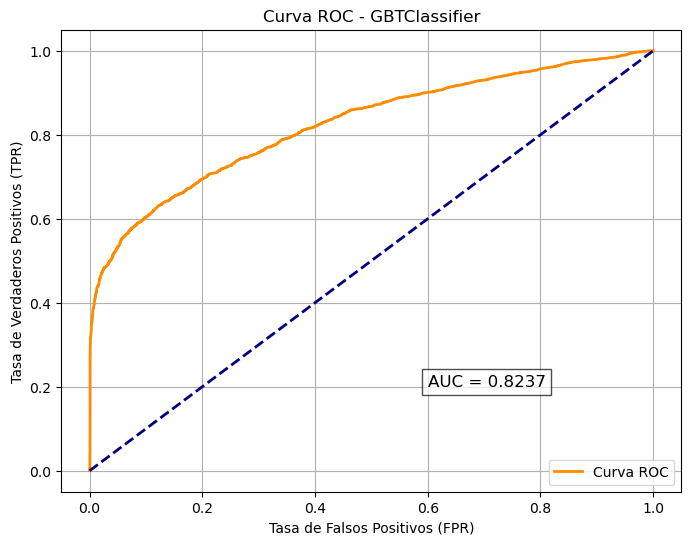

In [22]:
# Convertir a Pandas
roc_data = predictions_probability.toPandas()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular puntos de la curva ROC
fpr, tpr, thresholds = roc_curve(roc_data['label'], roc_data['probability_1'])
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Agregar texto con el valor AUC en el gráfico
plt.text(0.6, 0.2, f'AUC = {roc_auc:.4f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - GBTClassifier')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Graficar distribución de probabilidades

In [23]:
prob_dist = predictions_probability.toPandas()

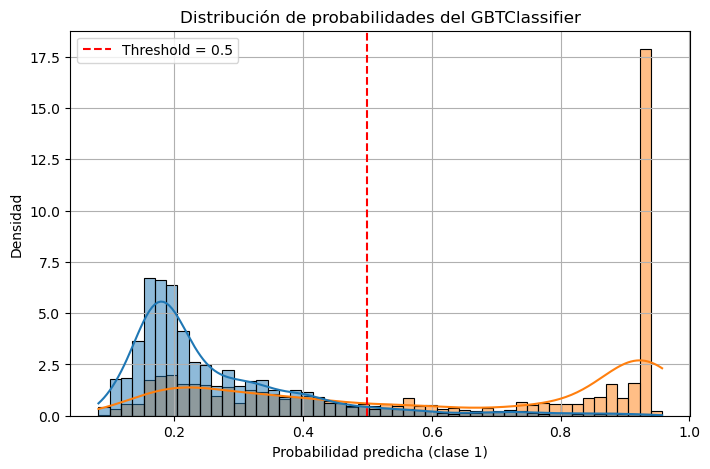

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(data=prob_dist, x="probability_1", hue="label", bins=50, kde=True, stat="density", common_norm=False)
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title("Distribución de probabilidades del GBTClassifier")
plt.xlabel("Probabilidad predicha (clase 1)")
plt.ylabel("Densidad")
plt.legend()
plt.grid()
plt.show()


### Graficando variabilidad de metricas conforme al treshold

C:\Users\amcr0\anaconda3\envs\env-pyspark\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\amcr0\anaconda3\envs\env-pyspark\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\amcr0\anaconda3\envs\env-pyspark\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\amcr

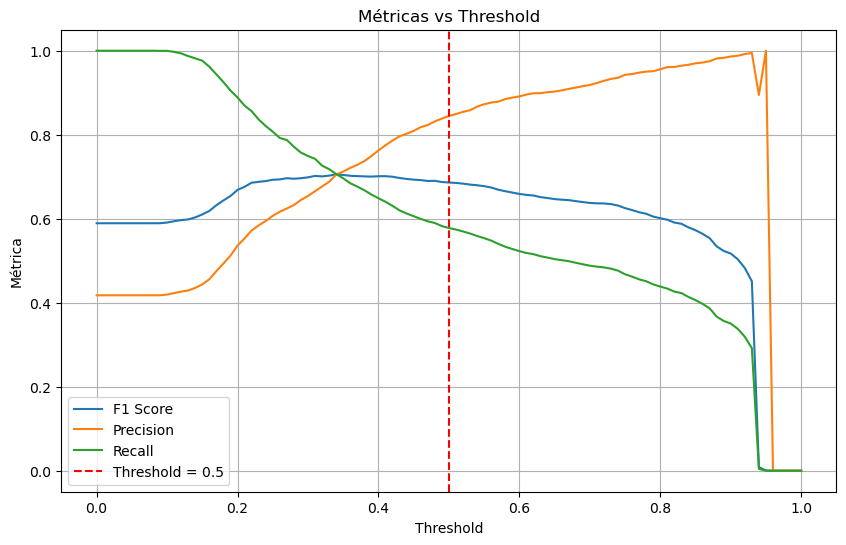

In [25]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.0, 1.01, 0.01)
f1s = []
precisions = []
recalls = []

for t in thresholds:
    preds = (prob_dist["probability_1"] >= t).astype(int)
    f1s.append(f1_score(prob_dist["label"], preds))
    precisions.append(precision_score(prob_dist["label"], preds))
    recalls.append(recall_score(prob_dist["label"], preds))

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.xlabel("Threshold")
plt.ylabel("Métrica")
plt.title("Métricas vs Threshold")
plt.legend()
plt.grid()
plt.show()

# **5. Análisis de resultados**



### *Métricas*
#### AUC (ROC)
Nos indica que el modelo está diferenciando bien las clases y que está clasificando mejor que el azar, teniendo un valor de 0.8237 con las pruebas anteriores.

#### Matríz de Confusión
Nos indica que tenemos todas las clasificaciones de nuestro modelo por cantidad de muestras clasificadas correctamente e incorrectamente. Se traduce a que vuelo si se retraso, cual no se retraso y que predicciones de retraso estuvieron correctas e incorrectas.

#### Recall
Nos indica que un total del	77.93% de los vuelos realmente retrasados serán detectados por el  modelo.

#### Precision
Nos indica que un total	del 79.14% de los vuelos predichos, efectivamente se habrán retrasado.

#### F1 Score
Entre mas cercano el valor a 1 nos va a indicar que se reduce la taza de vuelos mal predichos, tanto de manera positiva como negativa.

#### Accuracy
Nos indica que estamos clasificando de manera correcta un 77.93% de los datos de prueba, por lo que tiene un desempeño óptimo, pero puede mejorar. Esto se traduce que el 77.93% de las predicciones que hagamos, serán correctas. 

### *Conlcusión*
Conforme a las métricas anteriores podemos concluir que hemos reportado un buen desempeño del modelo en general. Esta clasificando de manera correcta los vuelos con un accuracy del 78%. La fortaleca principal del modelo actual se centra en que la metrica más alta es el "recall" por lo que hay una mayor proababilidad de que los vuelos que se hayan predicho, efectivamente se hayan retrasado casi con el 80% de certeza. Esto es muy importante para la aerolínea y torre de control porque así podremos peveer si se necesita hacer un cambio en la logística del aereopuerto con antelación a que el vuelo haya despegado o después de su despeuge.

Entre las métricas a mejorar sería aumentar el accuracy, ya que para una aereopuerto el porcentaje de éxito podría seguir considerandose bajo. Esto implica una mejora indirecta de todas las metricas. Entre mejorar recall y precision eligiría que es más improtante mejorar el recall porque para el aereopuerto es de mayor importancia garantizar que se están identificando todos los vuelos retrasados (VP+FN).

Podríamos en un futuro seguir mejorando el modelo. Para este caso únicamente se tomo como input al modelo la variable `DEP_TIME` y `DEP_DELAY`. Sin embargo hay otras variables que podríamos incluir en el modelo ya que se obtienen antes de que despegue el avión como: `TAXI_OUT`,`WHEELS_OFF`. Para este ejercicio se descartaron ya que se obtienen del calculo de la suma y resta de variables anteriores como `DEP_TIME` y `DEP_DELAY`, por lo que le añadiría un poco de información repetida al modelo. A pesar de ello, se podrían realizar diferentes pruebas seleccionando distintas variables para aumentar el desempeño del mismo.

También podríamos sumar complejidad al modelo agregarndo los vuelos que fueron desviados `DIVERTED`, aunque este dato no se conoce hasta que el vuelo esté en curso. 